In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [4]:
splits,info=tfds.load('horses_or_humans',as_supervised=True,with_info=True,split=['train[:80%]','train[80%:]','test'],data_dir='./data')

In [5]:
(train,validation,test)=splits

In [6]:
num_examples=info.splits['train'].num_examples
num_classes=info.features['label'].num_classes

In [7]:
BATCH_SIZE=32
IMAGE_SIZE=224

In [8]:
@tf.function
def map_fn(img,label):
  image_height=224
  image_width=224
  img=tf.image.resize(img,(224,224))
  img=img/225.0
  return img,label

In [9]:
def prepare_dataset(train,validation,test,num_examples,map_fn,batch_size):
  train_ds=train.map(map_fn).shuffle(buffer_size=num_examples).batch(batch_size)
  validation_ds=validation.map(map_fn).batch(batch_size)
  test_ds=test.map(map_fn).batch(batch_size)  
  return train_ds,validation_ds,test_ds 

In [10]:
train_ds,valid_ds,test_ds=prepare_dataset(train,validation,test,num_examples,map_fn,BATCH_SIZE)

In [11]:
model=tf.keras.Sequential([
                           hub.KerasLayer('https://tfhub.dev/tensorflow/resnet_50/feature_vector/1',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),trainable=False),
                           tf.keras.layers.Dense(num_classes,activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [12]:
def set_adam_optimizer():
    optimizer=tf.keras.optimizers.Adam() 
    return optimizer

In [13]:
def set_sparse_cat_crossentropy_loss():
    train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    val_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    return train_loss, val_loss

In [14]:
def set_sparse_cat_crossentropy_accuracy():
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy() 
    val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy() 
    return train_accuracy, val_accuracy

In [15]:
optimizer=set_adam_optimizer()
train_loss,val_loss=set_sparse_cat_crossentropy_loss()
train_accuracy,val_accuracy=set_sparse_cat_crossentropy_accuracy()

In [16]:
EPOCHS = 1

def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = train_loss(y, predictions)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads , model.trainable_weights))
    train_accuracy(y , predictions)
    return loss

In [17]:
@tf.function
def train(model, optimizer, epochs, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            step += 1
          
            loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

            for x, y in valid_ds:
                y_pred = model(x)
                loss = val_loss(y, y_pred)
                val_accuracy(y, y_pred)
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [18]:
train(model, optimizer, EPOCHS, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy)

Step 1 : train loss 0.830670476 ; train accuracy 0.46875
Step 2 : train loss 0.584470749 ; train accuracy 0.59375
Step 3 : train loss 0.413236916 ; train accuracy 0.6875
Step 4 : train loss 0.28435415 ; train accuracy 0.7578125
Step 5 : train loss 0.198592991 ; train accuracy 0.8
Step 6 : train loss 0.220567897 ; train accuracy 0.822916687
Step 7 : train loss 0.137348443 ; train accuracy 0.84375
Step 8 : train loss 0.086852394 ; train accuracy 0.86328125
Step 9 : train loss 0.058453057 ; train accuracy 0.878472209
Step 10 : train loss 0.0801330209 ; train accuracy 0.8875
Step 11 : train loss 0.0737676173 ; train accuracy 0.894886374
Step 12 : train loss 0.0226055197 ; train accuracy 0.903645813
Step 13 : train loss 0.026323827 ; train accuracy 0.911057711
Step 14 : train loss 0.0238874424 ; train accuracy 0.917410731
Step 15 : train loss 0.026718311 ; train accuracy 0.922916651
Step 16 : train loss 0.0152539574 ; train accuracy 0.927734375
Step 17 : train loss 0.0399940312 ; train accu

In [21]:
test_imgs=[]
test_labels=[]
predictions=[]
for images, labels in test_ds:
      preds=model(images)
      preds=preds.numpy()
      predictions.extend(preds)

      test_imgs.extend(images.numpy())
      test_labels.extend(labels.numpy())

In [22]:
class_names = ['horse','human']
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = np.squeeze(img)
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    print(true_label)
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

0


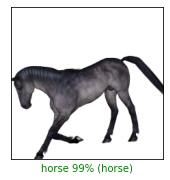

In [23]:
index=10
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()